In [1]:
#import libarary
import numpy as np 
import pandas as pd 
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
#difine input sequnece


In [2]:
seq_in = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(seq_in)
seq_in = seq_in.reshape((1, n_in, 1))
# prepare output sequence
seq_out = seq_in[:, 1:, :]
n_out = n_in - 1
# define encoder
visible = Input(shape=(n_in,1))
encoder = LSTM(100, activation='relu')(visible)
# define reconstruct decoder

In [3]:
#difine encoder
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(100, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(1))(decoder1)

In [4]:
#difine predict encoder 
dcoder2 = RepeatVector(n_out)(encoder)
dcoder2 =LSTM(100,activation= 'relu', return_sequences= True)(dcoder2)
decoder2 = TimeDistributed(Dense(1))(dcoder2)

In [5]:
model = Model(inputs=visible, outputs=[decoder1, decoder2])
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')
#fit model
model.fit(seq_in, [seq_in,seq_out], epochs=300, verbose=0)
# demonstrate prediction
yhat = model.predict(seq_in, verbose=True)
print(yhat)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
1/1 [==============================] - 1s 509ms/step
[array([[[0.10328613],
        [0.1996333 ],
        [0.29886663],
        [0.3992469 ],
        [0.49992883],
        [0.6004528 ],
        [0.70058274],
        [0.80025333],
        [0.899529  ]]], dtype=float32), array([[[0.1737356 ],
        [0.2958872 ],
        [0.40479416],
        [0.5051024 ],
        [0.60329723],
        [0.7006426 ],
        [0.79867715],
        [0.89892876]]], dtype=float32)]


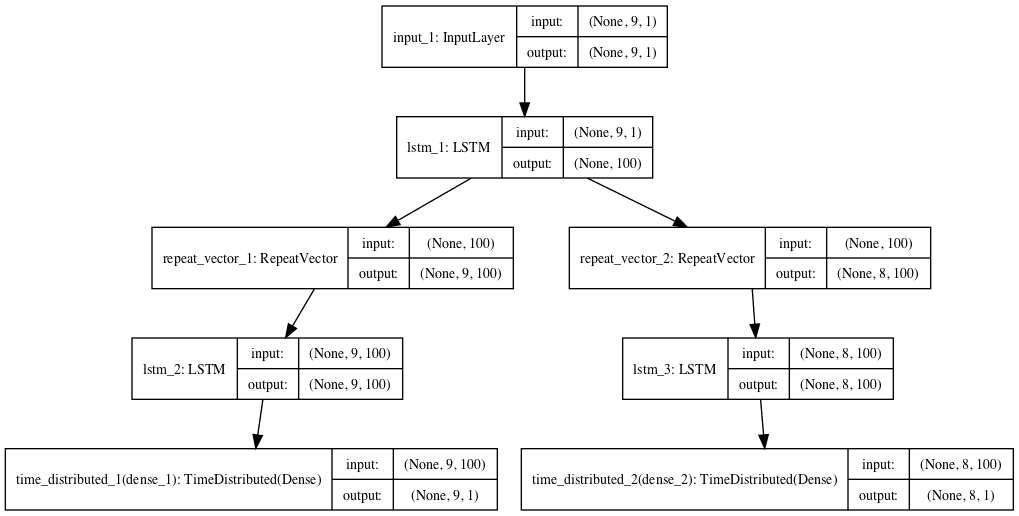




LSTM composite automatic encoder for sequence reconstruction and prediction

Keep the LSTM encoder independent
=
Regardless of the method chosen (reconstruction, prediction or combination), when the automatic encoder is suitable, the decoder can be removed and the encoder can be kept as a stand-alone model.


The encoder can then be used to convert input sequences to a fixed-length encoded vector.


We can do this by creating a new model that has the same inputs as our original model and exits directly from the end of the encoder model before the RepeatVector layer.

In [8]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='RMSprop', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=1)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=1)
print(yhat)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 4577.0181
Epoch 2/200
1/1 [==============================] - 0s 5ms/step - loss: 4248.7397
Epoch 3/200
1/1 [==============================] - 0s 6ms/step - loss: 3991.7214
Epoch 4/200
1/1 [==============================] - 0s 6ms/step - loss: 3734.6296
Epoch 5/200
1/1 [==============================] - 0s 6ms/step - loss: 3449.7324
Epoch 6/200
1/1 [==============================] - 0s 5ms/step - loss: 3115.8604
Epoch 7/200
1/1 [==============================] - 0s 5ms/step - loss: 2713.6018
Epoch 8/200
1/1 [==============================] - 0s 4ms/step - loss: 2237.7048
Epoch 9/200
1/1 [==============================] - 0s 5ms/step - loss: 1709.9357
Epoch 10/200
1/1 [==============================] - 0s 6ms/step - loss: 1179.5182
Epoch 11/200
1/1 [==============================] - 0s 6ms/step - loss: 717.0407
Epoch 12/200
1/1 [==============================] - 0s 6ms/step - loss: 392.7006
Epoch 13/200
1/1 [==========

Stacked LSTM
=
Multiple hidden LSTM layers can be stacked on top of each other in a model called the Stacked LSTM model.


An LSTM layer requires 3D input, and LSTMs generate 2D output by default as an interpretation of the end of the sequence.


We can give the LSTM output a value for each time step in the input data by setting the return_sequences = True argument in the layer. This allows us to have a 3D output from the hidden LSTM layer as input to the next layer.

So we can define Stacked LSTM as follows.

In [9]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D

In [10]:
# split a univariate sequence into samples
def splitsequnce(sequnce,n_steps):
    X, y  = list(), list()
    for i in range(len(sequnce)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequnce)-1 :
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequnce[i: end_ix],sequnce[end_ix]
        X.append(seq_x)
        X.append(seq_y)
    return array(X), array(y)                       

In [11]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

In [16]:
# difine model
model = Sequential()
model.add(ConvLSTM2D(filters=512, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#model fit
model.fit(X, y, epochs=300, verbose=True)
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
yhat = model.predict(x_input, verbose=True)
print(yhat)

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 5055.7358
Epoch 2/300
1/1 [==============================] - 0s 62ms/step - loss: 4819.3081
Epoch 3/300
1/1 [==============================] - 0s 63ms/step - loss: 4581.1968
Epoch 4/300
1/1 [==============================] - 0s 61ms/step - loss: 4336.0474
Epoch 5/300
1/1 [==============================] - 0s 62ms/step - loss: 4077.7476
Epoch 6/300
1/1 [==============================] - 0s 63ms/step - loss: 3798.5181
Epoch 7/300
1/1 [==============================] - 0s 66ms/step - loss: 3493.1472
Epoch 8/300
1/1 [==============================] - 0s 63ms/step - loss: 3160.1035
Epoch 9/300
1/1 [==============================] - 0s 68ms/step - loss: 2798.1433
Epoch 10/300
1/1 [==============================] - 0s 58ms/step - loss: 2411.6387
Epoch 11/300
1/1 [==============================] - 0s 60ms/step - loss: 2007.8767
Epoch 12/300
1/1 [==============================] - 0s 63ms/step - loss: 1600.6440
Epoch 13/300
1/